# LIAR CNN (TextCNN + metadata) — Clean & runnable

This notebook:
- Loads `train.tsv`, `valid.tsv`, `test.tsv` and optional `contextgroups.csv`
- Trains a **6-class** TextCNN model with metadata + history features
- Evaluates on VALID/TEST and saves: model (`.keras`), metrics (`.json`), tables (`.csv`), plots (`.png`)
- Trains an optional **3-class** mapped version (false-ish / mixed / true-ish)

Paths are the same as your original notebook.


In [1]:
import os, json
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


In [2]:
# Paths (same as your notebook)
TRAINPATH = "train.tsv"
VALIDPATH = "valid.tsv"
TESTPATH  = "test.tsv"
CONTEXTMAPCSV = "context_groups.csv"  # must contain columns: context, contextgroup

# Output folders
OUTDIR = "models"
METRICSDIR = "metrics"
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(METRICSDIR, exist_ok=True)

# Output files
OUTMODEL_6   = os.path.join(OUTDIR, "liar_softmax_6class.keras")
OUTMETRICS_6 = os.path.join(METRICSDIR, "liar_softmax_6class_metrics.json")

OUTMODEL_3   = os.path.join(OUTDIR, "liar_softmax_3class.keras")
OUTMETRICS_3 = os.path.join(METRICSDIR, "liar_softmax_3class_metrics.json")

# Training
BATCHSIZE = 64
EPOCHS = 10
LR = 1e-3
SEED = 42

tf.keras.utils.set_random_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass

# 6-class labels
LABELS_6 = ["pants-fire","FALSE","barely-true","half-true","mostly-true","TRUE"]
LABEL2ID_6 = {l:i for i,l in enumerate(LABELS_6)}
ID2LABEL_6 = {i:l for l,i in LABEL2ID_6.items()}

# Speaker credit history cols (5-d)
HISTCOLS = ["pantsonfirecounts","falsecounts","barelytruecounts","halftruecounts","mostlytruecounts"]


In [3]:
def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize/alias column names and ensure required columns exist.
    This avoids silent bugs where wrong column names create all-NA features.
    """
    df = df.copy()
    df = df.rename(columns={c: c.strip() for c in df.columns})

    aliases = {
        "speaker_job_title": "speakerjobtitle",
        "speaker_job": "speakerjobtitle",
        "job": "speakerjobtitle",

        "context_group": "contextgroup",
        "contextGroup": "contextgroup",

        "pants_on_fire_counts": "pantsonfirecounts",
        "false_counts": "falsecounts",
        "barely_true_counts": "barelytruecounts",
        "half_true_counts": "halftruecounts",
        "mostly_true_counts": "mostlytruecounts",
    }
    for src, dst in aliases.items():
        if src in df.columns and dst not in df.columns:
            df = df.rename(columns={src: dst})

    required_text = ["statement","label","speaker","party","state","context","speakerjobtitle"]
    for c in required_text:
        if c not in df.columns:
            df[c] = "NA"

    for c in HISTCOLS:
        if c not in df.columns:
            df[c] = 0.0

    return df


def add_context_group(df: pd.DataFrame, contextmapcsv: str) -> pd.DataFrame:
    df = df.copy()

    if contextmapcsv and os.path.exists(contextmapcsv):
        ctx = pd.read_csv(contextmapcsv)
        ctx = ctx.rename(columns={c: c.strip() for c in ctx.columns})
        if "context_group" in ctx.columns and "contextgroup" not in ctx.columns:
            ctx = ctx.rename(columns={"context_group": "contextgroup"})

        if not {"context","contextgroup"}.issubset(ctx.columns):
            raise ValueError(f"contextgroups.csv must have columns: context, contextgroup. Found: {list(ctx.columns)}")

        df = df.merge(ctx[["context","contextgroup"]], on="context", how="left")
        df["contextgroup"] = df["contextgroup"].fillna("Other")
    else:
        df["contextgroup"] = "Other"

    return df


def add_label_ids(df: pd.DataFrame, label2id: dict) -> pd.DataFrame:
    df = df.copy()
    df["labelid"] = df["label"].map(label2id)
    if df["labelid"].isna().any():
        bad = df.loc[df["labelid"].isna(), "label"].value_counts().head(20).to_dict()
        raise ValueError(f"Unknown labels found: {bad}")
    df["labelid"] = df["labelid"].astype(int)
    return df


def leakage_safe_history(df: pd.DataFrame) -> pd.DataFrame:
    """
    Paper warning: speaker credit history includes current statement,
    so subtract current label count to avoid leakage.
    """
    df = df.copy()
    decmap = {
        "pants-fire": "pantsonfirecounts",
        "FALSE": "falsecounts",
        "barely-true": "barelytruecounts",
        "half-true": "halftruecounts",
        "mostly-true": "mostlytruecounts",
        # TRUE often not included in 5-d vector
    }
    for lab, col in decmap.items():
        m = df["label"] == lab
        df.loc[m, col] = pd.to_numeric(df.loc[m, col], errors="coerce").fillna(0.0) - 1.0

    df[HISTCOLS] = df[HISTCOLS].apply(pd.to_numeric, errors="coerce").fillna(0.0).clip(lower=0.0)
    return df


def make_df(path: str, label2id: dict) -> pd.DataFrame:
    df = pd.read_csv(path, sep="\t")
    df = normalize_columns(df)
    df = add_context_group(df, CONTEXTMAPCSV)
    df = add_label_ids(df, label2id)
    df = leakage_safe_history(df)
    return df


In [4]:
traindf_6 = make_df(TRAINPATH, LABEL2ID_6)
validdf_6 = make_df(VALIDPATH, LABEL2ID_6)
testdf_6  = make_df(TESTPATH,  LABEL2ID_6)

print("Train:", traindf_6.shape, "Valid:", validdf_6.shape, "Test:", testdf_6.shape)


Train: (10284, 16) Valid: (1290, 16) Test: (1274, 16)


In [5]:
def sanity_check(df, name):
    print(f"\n== {name} ==")
    print("shape:", df.shape)
    print("columns:", list(df.columns))

    req = ["statement","label","labelid","speaker","party","state","context","speakerjobtitle","contextgroup"]
    missing = [c for c in req if c not in df.columns]
    if missing:
        raise ValueError(f"{name}: missing required columns: {missing}")

    for c in ["statement","label","speaker","party","state","context","speakerjobtitle","contextgroup"]:
        miss = (df[c].isna() | (df[c].astype(str).str.len()==0)).mean()
        print(f"{c:15s} missing-rate: {miss:.3f}")

    print("label counts:\n", df["label"].value_counts().head(15))
    print("contextgroup counts:\n", df["contextgroup"].value_counts().head(15))

sanity_check(traindf_6, "TRAIN")
sanity_check(validdf_6, "VALID")
sanity_check(testdf_6,  "TEST")



== TRAIN ==
shape: (10284, 16)
columns: ['id', 'label', 'statement', 'subjects', 'speaker', 'speakerjobtitle', 'state', 'party', 'barelytruecounts', 'falsecounts', 'halftruecounts', 'mostlytruecounts', 'pantsonfirecounts', 'context', 'contextgroup', 'labelid']
statement       missing-rate: 0.000
label           missing-rate: 0.000
speaker         missing-rate: 0.000
party           missing-rate: 0.000
state           missing-rate: 0.216
context         missing-rate: 0.010
speakerjobtitle missing-rate: 0.283
contextgroup    missing-rate: 0.000
label counts:
 label
half-true      2124
FALSE          2003
mostly-true    1967
TRUE           1679
barely-true    1668
pants-fire      843
Name: count, dtype: int64
contextgroup counts:
 contextgroup
Other                      1891
Interview                  1754
Campaign Ad                1224
Press Release/Statement    1189
Speech/Rally               1146
Debate                      739
TV/Radio                    697
News Article/Editorial  

In [6]:
def build_tf_dataset(df: pd.DataFrame, batchsize: int, shuffle: bool, num_classes: int) -> tf.data.Dataset:
    hist = df[HISTCOLS].astype(np.float32).to_numpy()

    X = {
        "statement": df["statement"].astype(str).fillna("").to_numpy(),
        "speaker": df["speaker"].astype(str).fillna("NA").to_numpy(),
        "party": df["party"].astype(str).fillna("NA").to_numpy(),
        "state": df["state"].astype(str).fillna("NA").to_numpy(),
        "speakerjobtitle": df["speakerjobtitle"].astype(str).fillna("NA").to_numpy(),
        "contextgroup": df["contextgroup"].astype(str).fillna("Other").to_numpy(),
        "history": hist,
    }

    y = tf.keras.utils.to_categorical(df["labelid"].to_numpy(), num_classes=num_classes).astype(np.float32)

    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(len(df), 50000), seed=SEED, reshuffle_each_iteration=True)

    return ds.batch(batchsize).prefetch(tf.data.AUTOTUNE)

train_ds_6 = build_tf_dataset(traindf_6, BATCHSIZE, shuffle=True,  num_classes=6)
valid_ds_6 = build_tf_dataset(validdf_6, BATCHSIZE, shuffle=False, num_classes=6)
test_ds_6  = build_tf_dataset(testdf_6,  BATCHSIZE, shuffle=False, num_classes=6)


In [7]:
def build_model(num_classes: int,
                vocab_size: int = 40000,
                text_len: int = 64,
                embed_dim: int = 128,
                cat_embed_dim: int = 32,
                text_cnn_filters: int = 128,
                dropout: float = 0.3,
                dense_dim: int = 256,
                speaker_max_tokens: int = 50000,
                job_max_tokens: int = 50000,
                party_max_tokens: int = 1000,
                state_max_tokens: int = 200,
                ctx_max_tokens: int = 50):

    statement = tf.keras.Input(shape=(), dtype=tf.string, name="statement")
    speaker = tf.keras.Input(shape=(), dtype=tf.string, name="speaker")
    party = tf.keras.Input(shape=(), dtype=tf.string, name="party")
    state = tf.keras.Input(shape=(), dtype=tf.string, name="state")
    speakerjobtitle = tf.keras.Input(shape=(), dtype=tf.string, name="speakerjobtitle")
    contextgroup = tf.keras.Input(shape=(), dtype=tf.string, name="contextgroup")
    history = tf.keras.Input(shape=(5,), dtype=tf.float32, name="history")

    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        output_sequence_length=text_len,
        standardize="lower_and_strip_punctuation",
    )

    x = vectorizer(statement)
    x = tf.keras.layers.Embedding(vocab_size, embed_dim, name="tok_emb")(x)

    convs = []
    for k in [2, 3, 4]:
        c = tf.keras.layers.Conv1D(text_cnn_filters, k, activation="relu", padding="same")(x)
        c = tf.keras.layers.GlobalMaxPooling1D()(c)
        convs.append(c)

    x = tf.keras.layers.Concatenate()(convs)
    x = tf.keras.layers.Dropout(dropout)(x)

    def cat_branch(inp, max_tokens, name):
        lookup = tf.keras.layers.StringLookup(max_tokens=max_tokens, output_mode="int", name=f"{name}_lookup")
        z = lookup(inp)
        z = tf.keras.layers.Embedding(max_tokens, cat_embed_dim, name=f"{name}_emb")(z)
        z = tf.keras.layers.Flatten()(z)
        return lookup, z

    speaker_lookup, z_speaker = cat_branch(speaker, speaker_max_tokens, "speaker")
    job_lookup, z_job = cat_branch(speakerjobtitle, job_max_tokens, "job")
    party_lookup, z_party = cat_branch(party, party_max_tokens, "party")
    state_lookup, z_state = cat_branch(state, state_max_tokens, "state")
    ctx_lookup, z_ctx = cat_branch(contextgroup, ctx_max_tokens, "ctx")

    h = tf.keras.layers.Concatenate()([x, z_speaker, z_job, z_party, z_state, z_ctx, history])
    h = tf.keras.layers.Dense(dense_dim, activation="relu")(h)
    h = tf.keras.layers.Dropout(dropout)(h)

    out = tf.keras.layers.Dense(num_classes, activation="softmax", name="y")(h)

    model = tf.keras.Model(
        inputs={
            "statement": statement,
            "speaker": speaker,
            "party": party,
            "state": state,
            "speakerjobtitle": speakerjobtitle,
            "contextgroup": contextgroup,
            "history": history,
        },
        outputs=out,
    )

    # attach preprocessors so we can adapt on train only
    model.vectorizer = vectorizer
    model.lookups = {
        "speaker": speaker_lookup,
        "job": job_lookup,
        "party": party_lookup,
        "state": state_lookup,
        "ctx": ctx_lookup,
    }
    return model


In [8]:
model_6 = build_model(num_classes=6)

# Adapt preprocessors on TRAIN only
model_6.vectorizer.adapt(traindf_6["statement"].astype(str).fillna("").to_numpy())
model_6.lookups["speaker"].adapt(traindf_6["speaker"].astype(str).fillna("NA").to_numpy())
model_6.lookups["job"].adapt(traindf_6["speakerjobtitle"].astype(str).fillna("NA").to_numpy())
model_6.lookups["party"].adapt(traindf_6["party"].astype(str).fillna("NA").to_numpy())
model_6.lookups["state"].adapt(traindf_6["state"].astype(str).fillna("NA").to_numpy())
model_6.lookups["ctx"].adapt(traindf_6["contextgroup"].astype(str).fillna("Other").to_numpy())

model_6.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss="categorical_crossentropy",
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")],
)

model_6.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ statement (InputLayer)        │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ text_vectorization            │ (None, 64)                │               0 │ statement[0][0]            │
│ (TextVectorization)           │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tok_emb (Embedding)           │ (None, 64, 128)           │       5,120,000 │ text_vectorization[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 64, 128)           │          32,896 │ tok_emb[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 64, 128)           │          49,280 │ tok_emb[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 64, 128)           │          65,664 │ tok_emb[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ speaker (InputLayer)          │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ speakerjobtitle (InputLayer)  │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ party (InputLayer)            │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ state (InputLayer)            │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ contextgroup (InputLayer)     │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d          │ (None, 128)               │               0 │ conv1d[0][0]               │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d_1        │ (None, 128)               │               0 │ conv1d_1[0][0]             │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d_2        │ (None, 128)               │               0 │ conv1d_2[0][0]             │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ speaker_lookup (StringLookup) │ (None)                    │               0 │ speaker[0][0]              │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 8,650,182 (33.00 MB)

 Trainable params: 8,650,182 (33.00 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#6 class

In [10]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5),
]

history_6 = model_6.fit(
    train_ds_6,
    validation_data=valid_ds_6,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2,
)


Epoch 1/10
161/161 - 18s - 109ms/step - acc: 0.2163 - loss: 2.2618 - val_acc: 0.2372 - val_loss: 1.7646 - learning_rate: 0.0010
Epoch 2/10
161/161 - 15s - 95ms/step - acc: 0.2619 - loss: 1.7702 - val_acc: 0.2589 - val_loss: 1.6751 - learning_rate: 0.0010
Epoch 3/10
161/161 - 15s - 95ms/step - acc: 0.3720 - loss: 1.5564 - val_acc: 0.2829 - val_loss: 1.6987 - learning_rate: 0.0010
Epoch 4/10
161/161 - 15s - 90ms/step - acc: 0.5863 - loss: 1.1387 - val_acc: 0.2783 - val_loss: 1.8062 - learning_rate: 5.0000e-04


In [11]:
def eval_split_model(model, df, ds, split_name, id2label):
    out = model.evaluate(ds, verbose=0)
    if isinstance(out, (list, tuple)):
        loss = float(out[0])
        acc_tf = float(out[1]) if len(out) > 1 else None
    else:
        loss = float(out)
        acc_tf = None

    y_prob = model.predict(ds, verbose=0)
    y_pred = y_prob.argmax(axis=1)
    y_true = df["labelid"].to_numpy()

    acc = float(accuracy_score(y_true, y_pred))
    macrof1 = float(f1_score(y_true, y_pred, average="macro", zero_division=0))
    report = classification_report(
        y_true,
        y_pred,
        target_names=[id2label[i] for i in range(len(id2label))],
        zero_division=0,
        output_dict=True,
    )
    cm = confusion_matrix(y_true, y_pred)

    print(f"{split_name}: loss={loss:.4f} acc={acc:.4f} macroF1={macrof1:.4f} acc_tf={acc_tf}")

    return {
        "loss": loss,
        "accuracy_tf": acc_tf,
        "accuracy": acc,
        "macrof1": macrof1,
        "report": report,
        "confusion_matrix": cm.tolist(),
    }


In [12]:
# --- Eval ---
valid_metrics_6 = eval_split_model(model_6, validdf_6, valid_ds_6, "VALID", ID2LABEL_6)
test_metrics_6  = eval_split_model(model_6, testdf_6,  test_ds_6,  "TEST",  ID2LABEL_6)

metrics_6 = {
    "labels": LABELS_6,
    "valid": valid_metrics_6,
    "test": test_metrics_6,
    "train_epochs_ran": len(history_6.history["loss"]),
}

# --- Save metrics JSON (keep this) ---
with open(OUTMETRICS_6, "w", encoding="utf-8") as f:
    json.dump(metrics_6, f, indent=2)

# --- Save weights only (no full-model saving) ---
weights_path_6 = os.path.join(OUTDIR, "liar_softmax_6class.weights.h5")
model_6.save_weights(weights_path_6)

print("Saved weights:", weights_path_6)
print("Saved metrics:", OUTMETRICS_6)


VALID: loss=1.6751 acc=0.2589 macroF1=0.2501 acc_tf=0.2589147388935089
TEST: loss=1.6839 acc=0.2716 macroF1=0.2533 acc_tf=0.2715855538845062
Saved weights: models\liar_softmax_6class.weights.h5
Saved metrics: metrics\liar_softmax_6class_metrics.json


In [13]:
best_idx = int(np.argmin(history_6.history["val_loss"]))
best_epoch = best_idx + 1

summary_6 = pd.DataFrame([
    {"Split": "Train (last epoch)", "Accuracy": history_6.history["acc"][-1], "Loss": history_6.history["loss"][-1], "Macro F1": np.nan},
    {"Split": f"Val (best epoch={best_epoch})", "Accuracy": history_6.history["val_acc"][best_idx], "Loss": history_6.history["val_loss"][best_idx], "Macro F1": valid_metrics_6["macrof1"]},
    {"Split": "Test (final)", "Accuracy": test_metrics_6["accuracy"], "Loss": test_metrics_6["loss"], "Macro F1": test_metrics_6["macrof1"]},
])

display(summary_6.style.format({"Accuracy":"{:.4f}","Loss":"{:.4f}","Macro F1":"{:.4f}"}))
summary_6_path = os.path.join(METRICSDIR, "summary_6class.csv")
summary_6.to_csv(summary_6_path, index=False)
print("Saved", summary_6_path)

# Per-class table from test report
rep = test_metrics_6["report"]
rows = []
for lab in LABELS_6:
    rows.append({
        "Class": lab,
        "Precision": rep[lab]["precision"],
        "Recall": rep[lab]["recall"],
        "F1": rep[lab]["f1-score"],
        "Support": int(rep[lab]["support"]),
    })
for avg in ["macro avg","weighted avg"]:
    rows.append({
        "Class": avg,
        "Precision": rep[avg]["precision"],
        "Recall": rep[avg]["recall"],
        "F1": rep[avg]["f1-score"],
        "Support": int(rep[avg]["support"]),
    })

perclass_6 = pd.DataFrame(rows)
display(perclass_6.style.format({"Precision":"{:.3f}","Recall":"{:.3f}","F1":"{:.3f}"}))
perclass_6_path = os.path.join(METRICSDIR, "perclass_6class.csv")
perclass_6.to_csv(perclass_6_path, index=False)
print("Saved", perclass_6_path)


,Split,Accuracy,Loss,Macro F1
0,Train (last epoch),0.5863,1.1387,nan
1,Val (best epoch=2),0.2589,1.6751,0.2501
2,Test (final),0.2716,1.6839,0.2533


Saved metrics\summary_6class.csv


,Class,Precision,Recall,F1,Support
0,pants-fire,0.459,0.183,0.262,93
1,FALSE,0.274,0.438,0.337,251
2,barely-true,0.239,0.079,0.119,214
3,half-true,0.226,0.406,0.291,266
4,mostly-true,0.320,0.195,0.242,241
5,TRUE,0.336,0.225,0.269,209
6,macro avg,0.309,0.254,0.253,1274
7,weighted avg,0.290,0.272,0.256,1274


Saved metrics\perclass_6class.csv


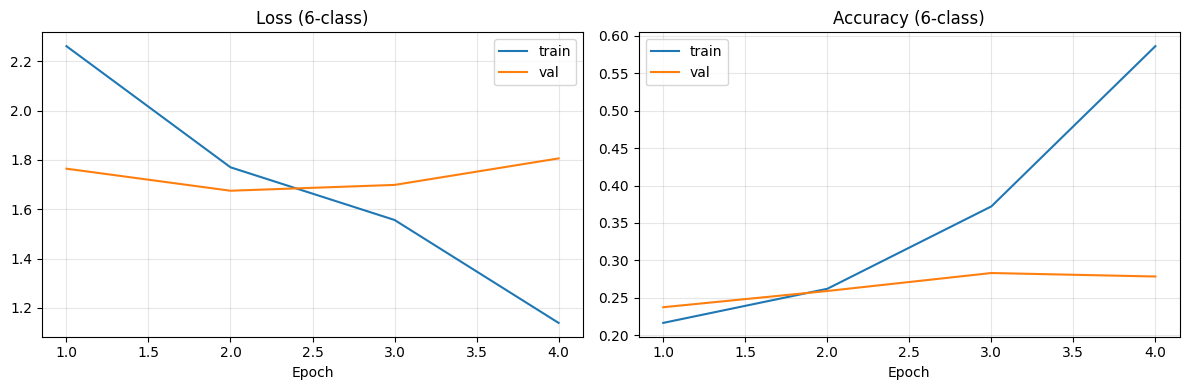

Saved metrics\training_curves_6class.png


In [14]:
epochs = np.arange(1, len(history_6.history["loss"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(epochs, history_6.history["loss"], label="train")
ax[0].plot(epochs, history_6.history["val_loss"], label="val")
ax[0].set_title("Loss (6-class)")
ax[0].set_xlabel("Epoch")
ax[0].grid(alpha=0.3)
ax[0].legend()

ax[1].plot(epochs, history_6.history["acc"], label="train")
ax[1].plot(epochs, history_6.history["val_acc"], label="val")
ax[1].set_title("Accuracy (6-class)")
ax[1].set_xlabel("Epoch")
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.tight_layout()
curves_path = os.path.join(METRICSDIR, "training_curves_6class.png")
plt.savefig(curves_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved", curves_path)


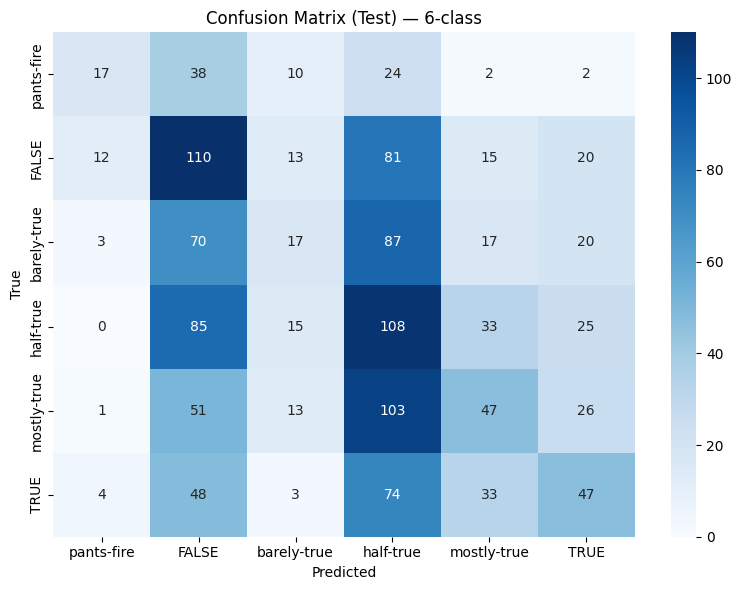

In [15]:
cm = np.array(test_metrics_6["confusion_matrix"])

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,          # <- show numbers
    fmt="d",             # integers
    cmap="Blues",
    xticklabels=LABELS_6,
    yticklabels=LABELS_6,
)
plt.title("Confusion Matrix (Test) — 6-class")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()



In [16]:
1

1

---

# 3-class mapping (false-ish / mixed / true-ish)

This section maps the 6 labels into 3 bins and trains the same architecture with `num_classes=3`.


In [17]:
MAP_3 = {
    "pants-fire": "false-ish",
    "FALSE": "false-ish",
    "barely-true": "mixed",
    "half-true": "mixed",
    "mostly-true": "true-ish",
    "TRUE": "true-ish",
}

LABELS_3 = ["false-ish", "mixed", "true-ish"]
LABEL2ID_3 = {l:i for i,l in enumerate(LABELS_3)}
ID2LABEL_3 = {i:l for l,i in LABEL2ID_3.items()}

def map_to_3class(df6: pd.DataFrame) -> pd.DataFrame:
    df = df6.copy()
    df["label3"] = df["label"].map(MAP_3)
    if df["label3"].isna().any():
        bad = df.loc[df["label3"].isna(), "label"].value_counts().to_dict()
        raise ValueError(f"Unmapped labels in 3-class mapping: {bad}")
    df["labelid"] = df["label3"].map(LABEL2ID_3).astype(int)
    return df

traindf_3 = map_to_3class(traindf_6)
validdf_3 = map_to_3class(validdf_6)
testdf_3  = map_to_3class(testdf_6)

train_ds_3 = build_tf_dataset(traindf_3, BATCHSIZE, shuffle=True,  num_classes=3)
valid_ds_3 = build_tf_dataset(validdf_3, BATCHSIZE, shuffle=False, num_classes=3)
test_ds_3  = build_tf_dataset(testdf_3,  BATCHSIZE, shuffle=False, num_classes=3)

print("3-class train/valid/test:", traindf_3.shape, validdf_3.shape, testdf_3.shape)
print("3-class label counts (train):\n", traindf_3["label3"].value_counts())


3-class train/valid/test: (10284, 17) (1290, 17) (1274, 17)
3-class label counts (train):
 label3
mixed        3792
true-ish     3646
false-ish    2846
Name: count, dtype: int64


In [18]:
model_3 = build_model(num_classes=3)

# Adapt on TRAIN only
model_3.vectorizer.adapt(traindf_3["statement"].astype(str).fillna("").to_numpy())
model_3.lookups["speaker"].adapt(traindf_3["speaker"].astype(str).fillna("NA").to_numpy())
model_3.lookups["job"].adapt(traindf_3["speakerjobtitle"].astype(str).fillna("NA").to_numpy())
model_3.lookups["party"].adapt(traindf_3["party"].astype(str).fillna("NA").to_numpy())
model_3.lookups["state"].adapt(traindf_3["state"].astype(str).fillna("NA").to_numpy())
model_3.lookups["ctx"].adapt(traindf_3["contextgroup"].astype(str).fillna("Other").to_numpy())

model_3.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss="categorical_crossentropy",
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")],
)

history_3 = model_3.fit(
    train_ds_3,
    validation_data=valid_ds_3,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2,
)


Epoch 1/10
161/161 - 18s - 114ms/step - acc: 0.4058 - loss: 1.4056 - val_acc: 0.4566 - val_loss: 1.0423 - learning_rate: 0.0010
Epoch 2/10
161/161 - 16s - 101ms/step - acc: 0.4930 - loss: 1.0814 - val_acc: 0.4543 - val_loss: 1.0434 - learning_rate: 0.0010
Epoch 3/10
161/161 - 16s - 100ms/step - acc: 0.6848 - loss: 0.7637 - val_acc: 0.4775 - val_loss: 1.0907 - learning_rate: 5.0000e-04


In [19]:
# --- Eval (3-class) ---
valid_metrics_3 = eval_split_model(model_3, validdf_3, valid_ds_3, "VALID-3", ID2LABEL_3)
test_metrics_3  = eval_split_model(model_3, testdf_3,  test_ds_3,  "TEST-3",  ID2LABEL_3)

metrics_3 = {
    "labels": LABELS_3,
    "valid": valid_metrics_3,
    "test": test_metrics_3,
    "train_epochs_ran": len(history_3.history["loss"]),
}

# --- Save metrics JSON ---
with open(OUTMETRICS_3, "w", encoding="utf-8") as f:
    json.dump(metrics_3, f, indent=2)

# --- Save weights only (no full model saving) ---
weights_path_3 = os.path.join(OUTDIR, "liar_softmax_3class.weights.h5")
model_3.save_weights(weights_path_3)

print("Saved weights:", weights_path_3)
print("Saved metrics:", OUTMETRICS_3)


VALID-3: loss=1.0423 acc=0.4566 macroF1=0.4117 acc_tf=0.45658913254737854
TEST-3: loss=1.0602 acc=0.4498 macroF1=0.4000 acc_tf=0.44976451992988586
Saved weights: models\liar_softmax_3class.weights.h5
Saved metrics: metrics\liar_softmax_3class_metrics.json


In [20]:
best_idx_3 = int(np.argmin(history_3.history["val_loss"]))
best_epoch_3 = best_idx_3 + 1

summary_3 = pd.DataFrame([
    {"Split": "Train (last epoch)", "Accuracy": history_3.history["acc"][-1], "Loss": history_3.history["loss"][-1], "Macro F1": np.nan},
    {"Split": f"Val (best epoch={best_epoch_3})", "Accuracy": history_3.history["val_acc"][best_idx_3], "Loss": history_3.history["val_loss"][best_idx_3], "Macro F1": valid_metrics_3["macrof1"]},
    {"Split": "Test (final)", "Accuracy": test_metrics_3["accuracy"], "Loss": test_metrics_3["loss"], "Macro F1": test_metrics_3["macrof1"]},
])

display(summary_3.style.format({"Accuracy":"{:.4f}","Loss":"{:.4f}","Macro F1":"{:.4f}"}))
summary_3_path = os.path.join(METRICSDIR, "summary_3class.csv")
summary_3.to_csv(summary_3_path, index=False)
print("Saved", summary_3_path)

# Per-class table from test report (3-class)
rep3 = test_metrics_3["report"]
rows3 = []
for lab in LABELS_3:
    rows3.append({
        "Class": lab,
        "Precision": rep3[lab]["precision"],
        "Recall": rep3[lab]["recall"],
        "F1": rep3[lab]["f1-score"],
        "Support": int(rep3[lab]["support"]),
    })

for avg in ["macro avg", "weighted avg"]:
    rows3.append({
        "Class": avg,
        "Precision": rep3[avg]["precision"],
        "Recall": rep3[avg]["recall"],
        "F1": rep3[avg]["f1-score"],
        "Support": int(rep3[avg]["support"]),
    })

perclass_3 = pd.DataFrame(rows3)
display(perclass_3.style.format({"Precision":"{:.3f}","Recall":"{:.3f}","F1":"{:.3f}"}))
perclass_3_path = os.path.join(METRICSDIR, "perclass_3class.csv")
perclass_3.to_csv(perclass_3_path, index=False)
print("Saved", perclass_3_path)


,Split,Accuracy,Loss,Macro F1
0,Train (last epoch),0.6848,0.7637,nan
1,Val (best epoch=1),0.4566,1.0423,0.4117
2,Test (final),0.4498,1.0602,0.4000


Saved metrics\summary_3class.csv


,Class,Precision,Recall,F1,Support
0,false-ish,0.581,0.145,0.233,344
1,mixed,0.410,0.725,0.524,480
2,true-ish,0.516,0.389,0.444,450
3,macro avg,0.503,0.420,0.400,1274
4,weighted avg,0.494,0.450,0.417,1274


Saved metrics\perclass_3class.csv


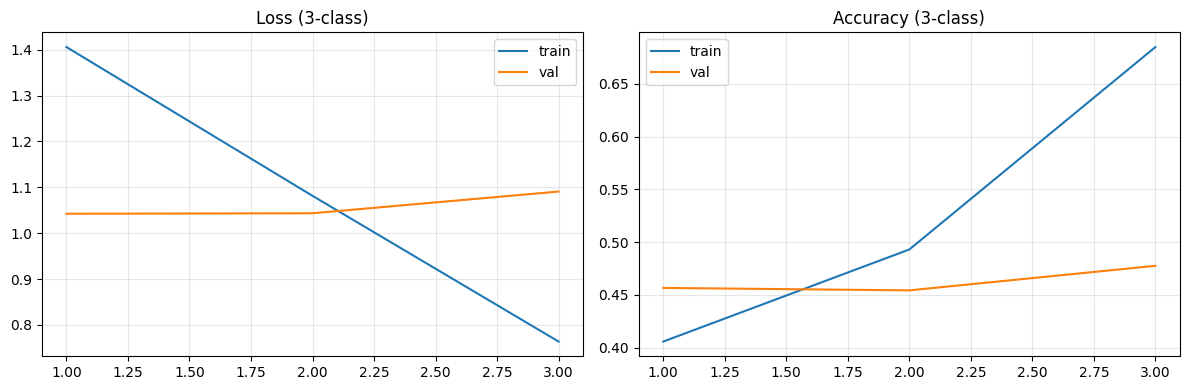

Saved metrics\training_curves_3class.png


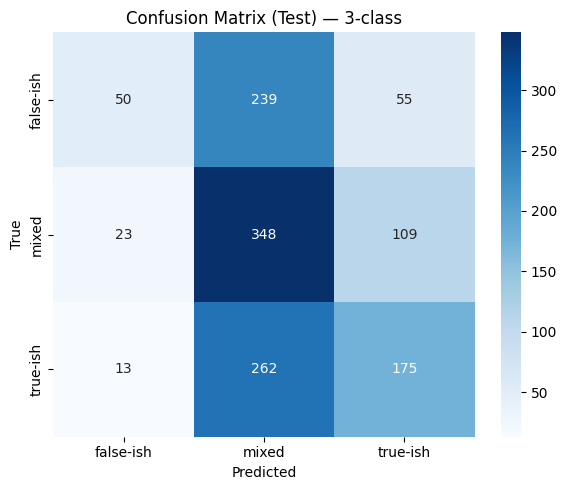

Saved metrics\confusion_matrix_3class.png


In [21]:
epochs = np.arange(1, len(history_3.history["loss"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(epochs, history_3.history["loss"], label="train")
ax[0].plot(epochs, history_3.history["val_loss"], label="val")
ax[0].set_title("Loss (3-class)")
ax[0].grid(alpha=0.3)
ax[0].legend()

ax[1].plot(epochs, history_3.history["acc"], label="train")
ax[1].plot(epochs, history_3.history["val_acc"], label="val")
ax[1].set_title("Accuracy (3-class)")
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.tight_layout()
curves_path = os.path.join(METRICSDIR, "training_curves_3class.png")
plt.savefig(curves_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved", curves_path)

cm3 = np.array(test_metrics_3["confusion_matrix"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm3, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS_3, yticklabels=LABELS_3)
plt.title("Confusion Matrix (Test) — 3-class")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
cm_path = os.path.join(METRICSDIR, "confusion_matrix_3class.png")
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved", cm_path)


In [22]:
1

1

In [23]:
y_prob = model_6.predict(test_ds_6, verbose=0)
y_pred = y_prob.argmax(axis=1)
import numpy as np
print("Pred counts:", np.bincount(y_pred, minlength=6))
print("Pred labels:", {LABELS_6[i]: int((y_pred==i).sum()) for i in range(6)})


Pred counts: [ 37 402  71 477 147 140]
Pred labels: {'pants-fire': 37, 'FALSE': 402, 'barely-true': 71, 'half-true': 477, 'mostly-true': 147, 'TRUE': 140}


In [24]:
1

1

In [25]:
import os, pandas as pd

print("contextgroups exists:", os.path.exists(CONTEXTMAPCSV))

ctx = pd.read_csv(CONTEXTMAPCSV)
print("ctx columns:", ctx.columns.tolist())
print("unique ctx contexts:", ctx["context"].nunique())
print("sample ctx context:", ctx["context"].dropna().astype(str).head().tolist())

print("train unique contexts:", traindf6["context"].nunique())
m = traindf6.merge(ctx[["context","contextgroup"]], on="context", how="left")
print("match rate:", m["contextgroup"].notna().mean())


contextgroups exists: True
ctx columns: ['context', 'context_group']
unique ctx contexts: 5139
sample ctx context: ['a mailer', 'a floor speech.', 'Denver', 'a news release', 'an interview on CNN']


NameError: name 'traindf6' is not defined